In [1]:
%load_ext jupyter_black

In [2]:
import pandas as pd
import geopandas as gpd
import shapely
from pathlib import Path
from shapely.geometry import Point
import warnings
from utils.pandas import lowercase_columns
from shapely.geometry import shape
import numpy as np
from utils.data import zero_pad
import os

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from utils.io import yaml_to_dict
from utils.data import zero_pad

DATA_DIR = Path("/Volumes/Samsung_T5/data")
ROOT_DIR = Path("/Users/lindseygulden/dev/leg-up")
from utils.datasets import get_county_df, get_us_state_to_abbr_dict

us_state_abbr_dict = get_us_state_to_abbr_dict()
county_info_df = get_county_df()

# switch the order
# state_abbr_dict={l: s for s, l in abbr_state_dict.items()}

In [3]:
# Open data soft's US county boundaries data; https://public.opendatasoft.com.geojson'))
counties_gdf = gpd.read_file(DATA_DIR / Path("us_geo/us-county-boundaries.geojson"))
counties_gdf = lowercase_columns(counties_gdf)
counties_gdf["area_m2"] = [
    a + w for a, w in zip(counties_gdf.aland, counties_gdf.awater)
]
counties_gdf["area_km2"] = counties_gdf.area_m2 / 1000000.0

In [4]:
# get US state outlines
us_gdf = gpd.read_file(DATA_DIR / Path("us_geo/us_states.json"))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
sns.histplot(data=ihs_join_counties_df, x="year", bins=100, ax=ax)
ax.set_title("Number of square miles in US with active oil and gas drilling")
ax.grid()
ax.set_xlim([1885, 2020])

In [164]:
ihs_df = pd.read_csv(
    DATA_DIR / Path("oilgas/processed_data/ihs_fips_stats_by_county.csv"),
    index_col=[0],
)
# "/Volumes/Samsung_T5/data/oilgas/processed_data/ihs_with_drilling_intensity.csv",

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ihs_gdf.plot(column="count_well_per_km2", ax=ax, legend=True, cmap="magma_r")
us_gdf.to_crs(counties_gdf.crs).plot(ax=ax, facecolor="none", edgecolor="black")
ax.set_xlim(-125, -68)
ax.set_ylim(25, 50)
ax.set_title("Oil & Gas wells per km2")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ihs_gdf.plot(column="mean_exposure_years_well", ax=ax, legend=True, cmap="magma")
us_gdf.to_crs(counties_gdf.crs).plot(ax=ax, facecolor="none", edgecolor="black")
ax.set_xlim(-125, -68)
ax.set_ylim(25, 50)
ax.set_title("Mean years' exposure to oil and gas drilling")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), width_ratios=[16, 6])
ihs_gdf.plot(
    column="intensity_well_yr_per_km2", ax=axes[0], legend=True, cmap="viridis"
)
us_gdf.to_crs(counties_gdf.crs).plot(
    ax=ax, facecolor="none", edgecolor="white", linewidth=2
)
axes[0].set_xlim(-125, -68)
axes[0].set_ylim(25, 50)
axes[0].set_title("Drilling intensity [well-yrs/km2]")

sns.histplot(data=ihs_gdf, x="intensity_well_yr_per_km2", bins=100, ax=axes[1])
axes[1].set_yscale("log")
axes[1].grid()
axes[1].set_title("Drilling intensity [well-yrs/km2]")
fig.tight_layout()

In [7]:
precip_df = pd.read_csv(
    DATA_DIR / Path("ncei_noaa_precip_in_county_1901_2000_annual_mean.csv")
)
precip_df.columns = [x.lower() for x in precip_df.columns.values]
precip_df.rename(columns={"id": "pseudo_fips"}, inplace=True)

In [8]:
precip_df = precip_df.merge(us_gdf[["name", "id"]], left_on="state", right_on="name")

In [9]:
precip_df["fips"] = [
    i + f.split("-")[1] for i, f in zip(precip_df.id, precip_df.pseudo_fips)
]
precip_df = precip_df[["fips", "1901-2000 mean"]]
precip_df.columns = ["fips", "mean_annual_precip_in"]

In [10]:
xl = pd.ExcelFile(DATA_DIR / Path("health/2023_County_Health_Rankings_Data_v2.xlsx"))
xl.sheet_names
additional_df = xl.parse("Additional Measure Data")
additional_df.columns = additional_df.loc[0, :]
additional_df = additional_df.loc[1:, :]
additional_df.columns = [x.lower() for x in additional_df.columns.values]
additional_df.fips = [
    zero_pad(x, front_or_back="front", max_string_length=5) for x in additional_df.fips
]
additional_df = additional_df.loc[[x[:3] != "000" for x in additional_df["fips"]]]
turnout_df = additional_df[["fips", "% voter turnout", "% census participation"]]

In [11]:
for c in ["% voter turnout", "% census participation"]:
    turnout_df[c] = turnout_df[c].astype(float)

In [165]:
cancer_df = pd.read_csv(
    DATA_DIR / Path("health/ihme_all_cancers_age_adjusted_mortality_rate_2014.csv"),
    index_col=[0],
)
risk_df = pd.read_csv(
    DATA_DIR / Path("health/2014_assembled_county_statistics.csv"), index_col=[0]
)
water_df = pd.read_csv(
    DATA_DIR / Path("us_drinking_water_source_by_county.csv"), index_col=[0]
)
cvd_df = pd.read_csv(
    DATA_DIR / Path("health/ihme_cvd_age_adjusted_mortality_rate_2014.csv"),
    index_col=[0],
)
cvd_df.fips = [
    zero_pad(x, front_or_back="front", max_string_length=5) for x in cvd_df.fips
]
cancer_df.fips = [
    zero_pad(x, front_or_back="front", max_string_length=5) for x in cancer_df.fips
]
risk_df.fips = [
    zero_pad(x, front_or_back="front", max_string_length=5) for x in risk_df.fips
]
ihs_df.geoid = [
    zero_pad(x, front_or_back="front", max_string_length=5) for x in ihs_df.geoid
]
water_df.fips = [
    zero_pad(x, front_or_back="front", max_string_length=5) for x in water_df.fips
]

In [166]:
ihs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3233 entries, 0 to 3232
Data columns (total 96 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   geoid                                 3233 non-null   object 
 1   name                                  3233 non-null   object 
 2   state_name                            3233 non-null   object 
 3   area_km2                              3233 non-null   float64
 4   geometry                              3233 non-null   object 
 5   count_well                            3233 non-null   float64
 6   count_oil_well                        3233 non-null   float64
 7   count_gas_well                        3233 non-null   float64
 8   count_dry_well                        3233 non-null   float64
 9   count_injection_well                  3233 non-null   float64
 10  count_horizontal_well                 3233 non-null   float64
 11  count_fractured_well  

In [167]:
df = (
    cancer_df.merge(risk_df, on="fips")
    .merge(cvd_df, on="fips")
    .merge(water_df, on="fips")
    .merge(turnout_df, on="fips")
    .merge(precip_df, on="fips")
    .merge(ihs_df, left_on="fips", right_on="geoid")
)

In [168]:
for c in df.columns.values:
    if "count_" in c:
        df[c] = df[c].fillna(0)

In [169]:
cancers = [
    "stomach_2014",
    "colon_and_rectum_2014",
    "liver_2014",
    "tracheal,_bronchus,_and_lung__2014",
    "nonmelanoma_skin_2014",
    "kidney_2014",
    "brain_and_nervous_system_2014",
    "hodgkin_lymphoma_2014",
    "nonhodgkin_lymphoma_2014",
    "acute_lymphoid_leukemia_2014",
    "chronic_lymphoid_leukemia_2014",
    "acute_myeloid_leukemia_2014",
]
cvds = [
    "cardiovascular_diseases_2014",
    "rheumatic_heart_disease_2014",
    "ischemic_heart_disease_2014",
    "cerebrovascular_disease_2014",
    "ischemic_stroke_2014",
    "hemorrhagic_stroke_2014",
    "hypertensive_heart_disease_2014",
    "cardiomyopathy_and_myocarditis_2014",
    "atrial_fibrillation_and_flutter_2014",
    "aortic_aneurysm_2014",
    "peripheral_vascular_disease_2014",
    "endocarditis_2014",
    "other_cardiovascular_2014",
]

In [204]:
df[cvds].corrwith(df["intensity_well_yr_per_km2"])

cardiovascular_diseases_2014            0.211364
rheumatic_heart_disease_2014            0.039858
ischemic_heart_disease_2014             0.213298
cerebrovascular_disease_2014            0.117560
ischemic_stroke_2014                    0.106829
hemorrhagic_stroke_2014                 0.114325
hypertensive_heart_disease_2014         0.128521
cardiomyopathy_and_myocarditis_2014     0.030884
atrial_fibrillation_and_flutter_2014   -0.075659
aortic_aneurysm_2014                   -0.001578
peripheral_vascular_disease_2014        0.086619
endocarditis_2014                       0.042335
other_cardiovascular_2014              -0.054400
dtype: float64

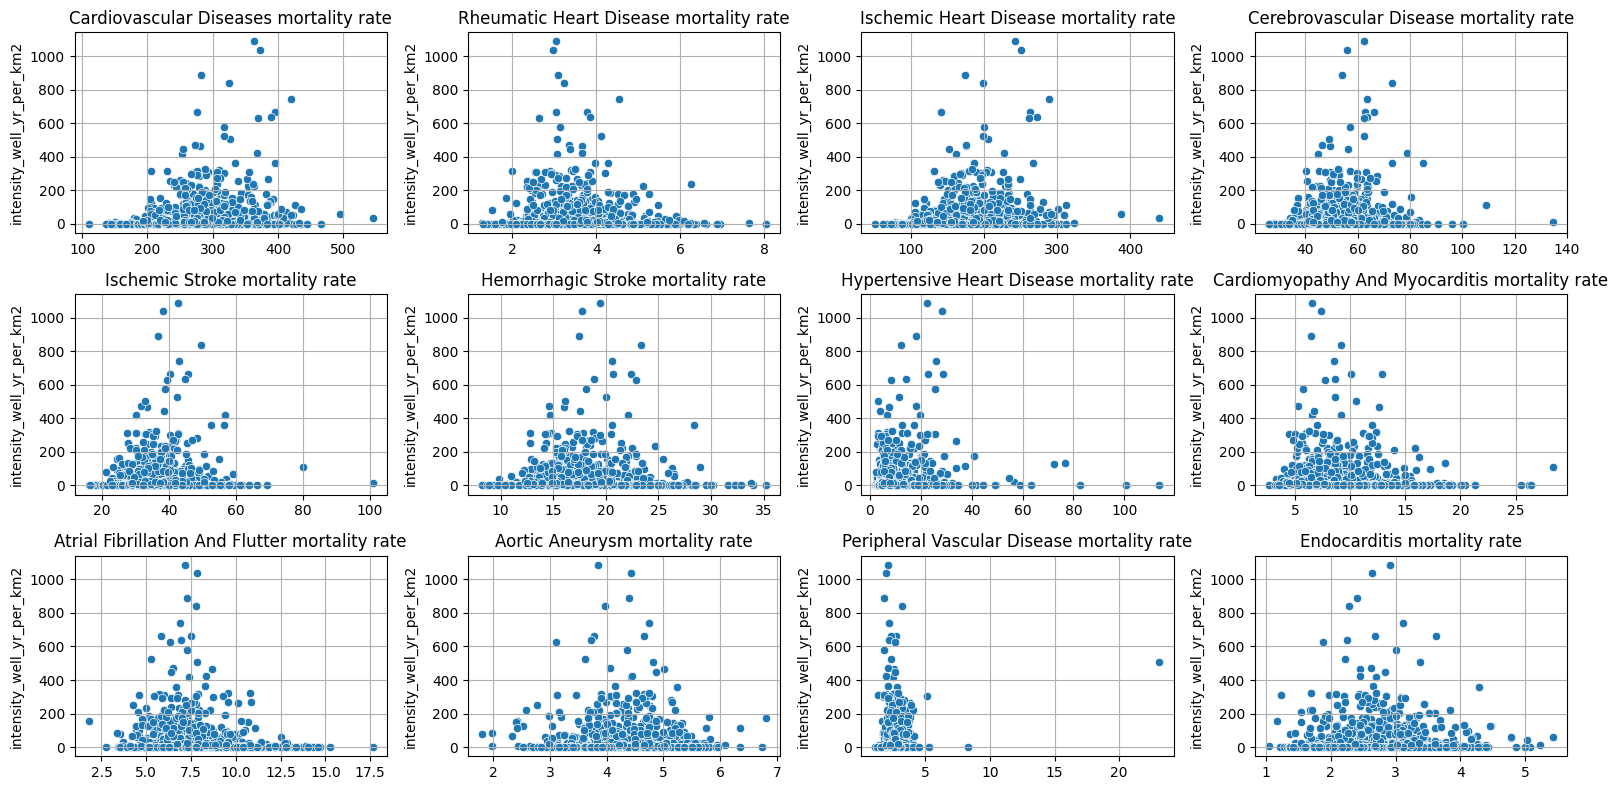

In [203]:
# cvd mortality rates
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
for i, ax in enumerate(axes.reshape(-1)):
    sns.scatterplot(data=df, x=cvds[i], y="intensity_well_yr_per_km2", ax=ax)
    ax.set_title(
        cvds[i].replace("_", " ").replace(" 2014", "").title() + " mortality rate"
    )
    ax.set_xlabel("")
    ax.grid()
fig.tight_layout()

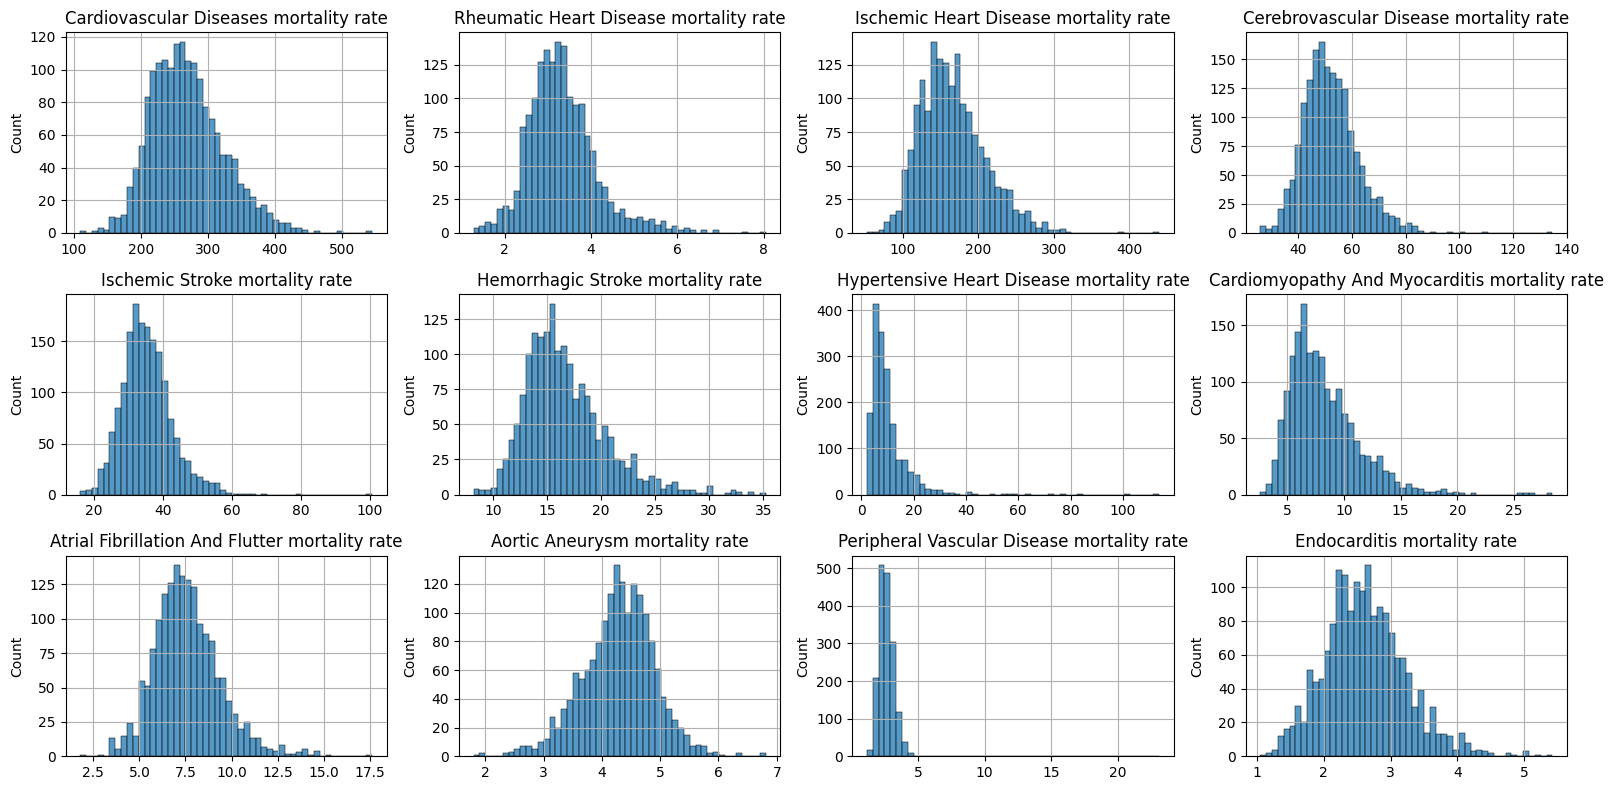

In [200]:
# cvd mortality rates
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
for i, ax in enumerate(axes.reshape(-1)):
    sns.histplot(data=df, x=cvds[i], ax=ax, bins=50)
    ax.set_title(
        cvds[i].replace("_", " ").replace(" 2014", "").title() + " mortality rate"
    )
    ax.set_xlabel("")
    ax.grid()
fig.tight_layout()

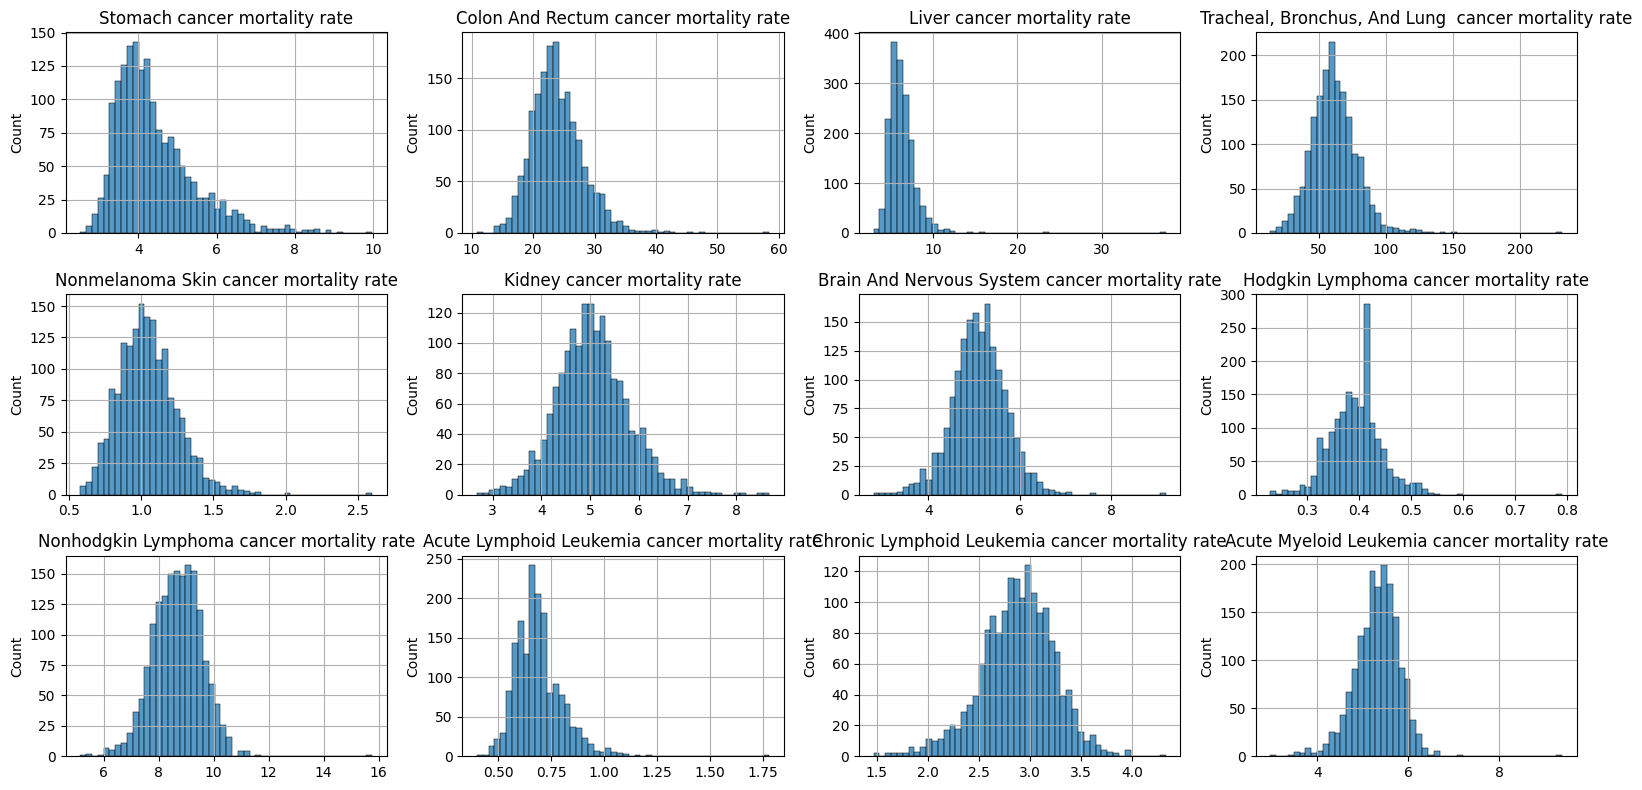

In [170]:
# cancer mortality rates
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
for i, ax in enumerate(axes.reshape(-1)):
    sns.histplot(data=df, x=cancers[i], ax=ax, bins=50)
    ax.set_title(
        cancers[i].replace("_", " ").replace(" 2014", "").title()
        + " cancer mortality rate"
    )
    ax.set_xlabel("")
    ax.grid()
fig.tight_layout()

In [171]:
y_targets = [
    "neoplasms_2014",
    "lip_and_oral_cavity_2014",
    "nasopharynx_2014",
    "other_pharynx_2014",
    "esophageal_2014",
    "stomach_2014",
    "colon_and_rectum_2014",
    "liver_2014",
    "gallbladder_and_biliary_tract__2014",
    "pancreatic_2014",
    "larynx_2014",
    "tracheal,_bronchus,_and_lung__2014",
    "malignant_skin_melanoma_2014",
    "nonmelanoma_skin_2014",
    "breast_2014",
    "cervical_2014",
    "uterine_2014",
    "ovarian_2014",
    "prostate_2014",
    "testicular_2014",
    "kidney_2014",
    "bladder_2014",
    "brain_and_nervous_system_2014",
    "thyroid_2014",
    "mesothelioma_2014",
    "hodgkin_lymphoma_2014",
    "nonhodgkin_lymphoma_2014",
    "multiple_myeloma_2014",
    "leukemia_2014",
    "acute_lymphoid_leukemia_2014",
    "chronic_lymphoid_leukemia_2014",
    "acute_myeloid_leukemia_2014",
    "chronic_myeloid_leukemia_2014",
    "other_neoplasms_2014",
]
x_vars = [x for x in df.columns.values if (x not in y_targets) and (x != "fips")]

X_df = df[x_vars + ["fips"]].copy(deep=True)
y_df = df["kidney_2014"].copy(deep=True)

In [205]:
risk_cols = [
    "pct_smokers",
    "pct_obese",
    "pct_lbw",
    "pct_physically_inactive",
    "pct_excessive_drinking",
    # "pct_alcohol_impaired",
    "pct_uninsured",
    "pcp_ratio",
    "dentist_ratio",
    "acsc_rate",
    # "pct_hba1c",
    "pct_mammography",
    "chlamydia_rate",
    "graduation_rate",
    # "pct_some_college",
    "pct_unemployed",
    "pct_children_in_poverty",
    "pct_no_social_emotional_support",
    #  "pct_single_parent_households",
    #  "violent_crime_rate",
    #  "injury_death_rate",
    # "pct_pop_in_viol",
    # "pct_severe_housing_problems",
    "pct_drive_alone",
    # "lt_18",
    # "65_and_over",
    "african_american",
    "american_indian_alaskan_native",
    "asian",
    # "native_hawaiian_other_pacific_islander",
    "hispanic",
    "nonhispanic_white",
    "pct_not_proficient_in_english",
    "pct_diabetic",
    "pct_food_insecure",
    "pct_limited_access",
    #  "pct_uninsured_adults",
    "household_income",
    "% voter turnout",
    "% census participation",
    "mean_annual_precip_in",
]
water_cols = [
    "pct_population_ground_water",
    "pct_population_ground_water_purchased",
    "pct_population_groundwater_under_influence_of_surface_water",
    "pct_population_surface_water",
    "pct_population_surface_water_purchased",
    "pct_population_local_water",
    "pct_population_purchased_water",
]

intensity_cols = [
    "intensity_well_yr_per_km2",
    "intensity_oil_well_yr_per_km2",
    "intensity_gas_well_yr_per_km2",
    "intensity_dry_well_yr_per_km2",
    "intensity_injection_well_yr_per_km2",
    "intensity_horizontal_well_yr_per_km2",
    "intensity_fractured_well_yr_per_km2",
]

og_count_cols = [
    "count_oil_well_per_km2",
    "count_gas_well_per_km2",
    "count_dry_well_per_km2",
    "count_injection_well_per_km2",
]

og_exposure_cols = [
    "mean_exposure_years_oil_well",
    "mean_exposure_years_gas_well",
    "mean_exposure_years_dry_well",
    #    "mean_exposure_years_injection_well",
    #    "mean_exposure_years_horizontal_well",
    #    "mean_exposure_years_fractured_well",
]

og_time_cols = [
    "count_1950_well_per_km2",
    "count_1960_well_per_km2",
    "count_1970_well_per_km2",
    "count_1980_well_per_km2",
]

cancer_cols = y_targets

og_total_intensity_col = [
    "intensity_well_yr_per_km2",
]
og_type_intensity_col = [
    "intensity_oil_well_yr_per_km2",
    "intensity_gas_well_yr_per_km2",
    "intensity_dry_well_yr_per_km2",
]

og_total_cols = ["count_well_per_km2"]

all_cols = (
    og_type_intensity_col + og_time_cols + og_exposure_cols + water_cols + risk_cols
)
# all_cols= og_total_cols + og_total_intensity_col + water_cols + risk_cols
feature_cols = risk_cols + water_cols + og_total_cols

<Axes: >

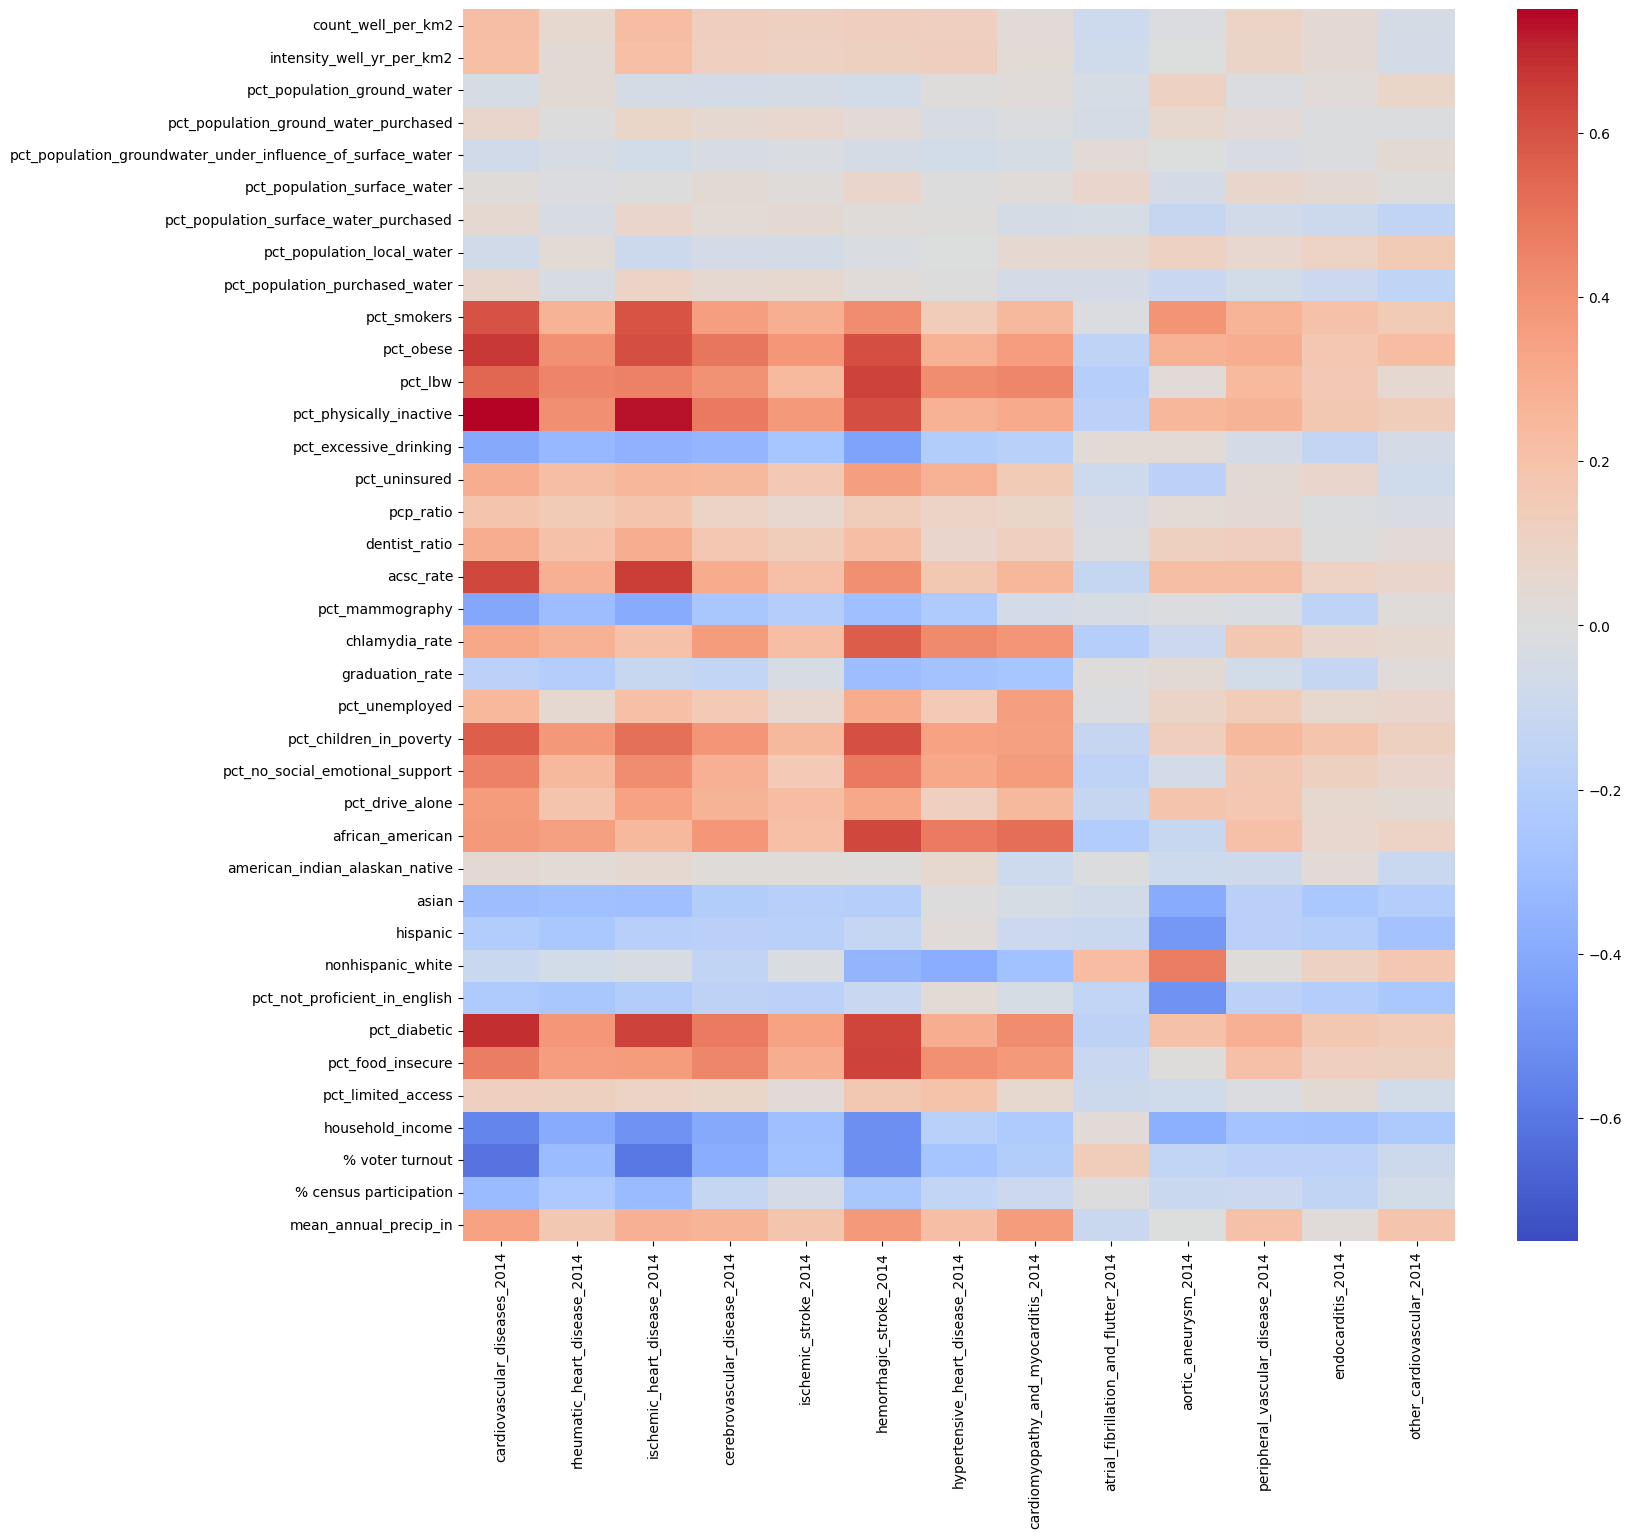

In [174]:
corr_df = df.dropna().select_dtypes(include=np.number).corr()
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(
    data=corr_df.loc[cvds, all_cols].T,
    cmap="coolwarm",
    vmin=-0.75,
    vmax=0.75,
    ax=ax,
)

<Axes: >

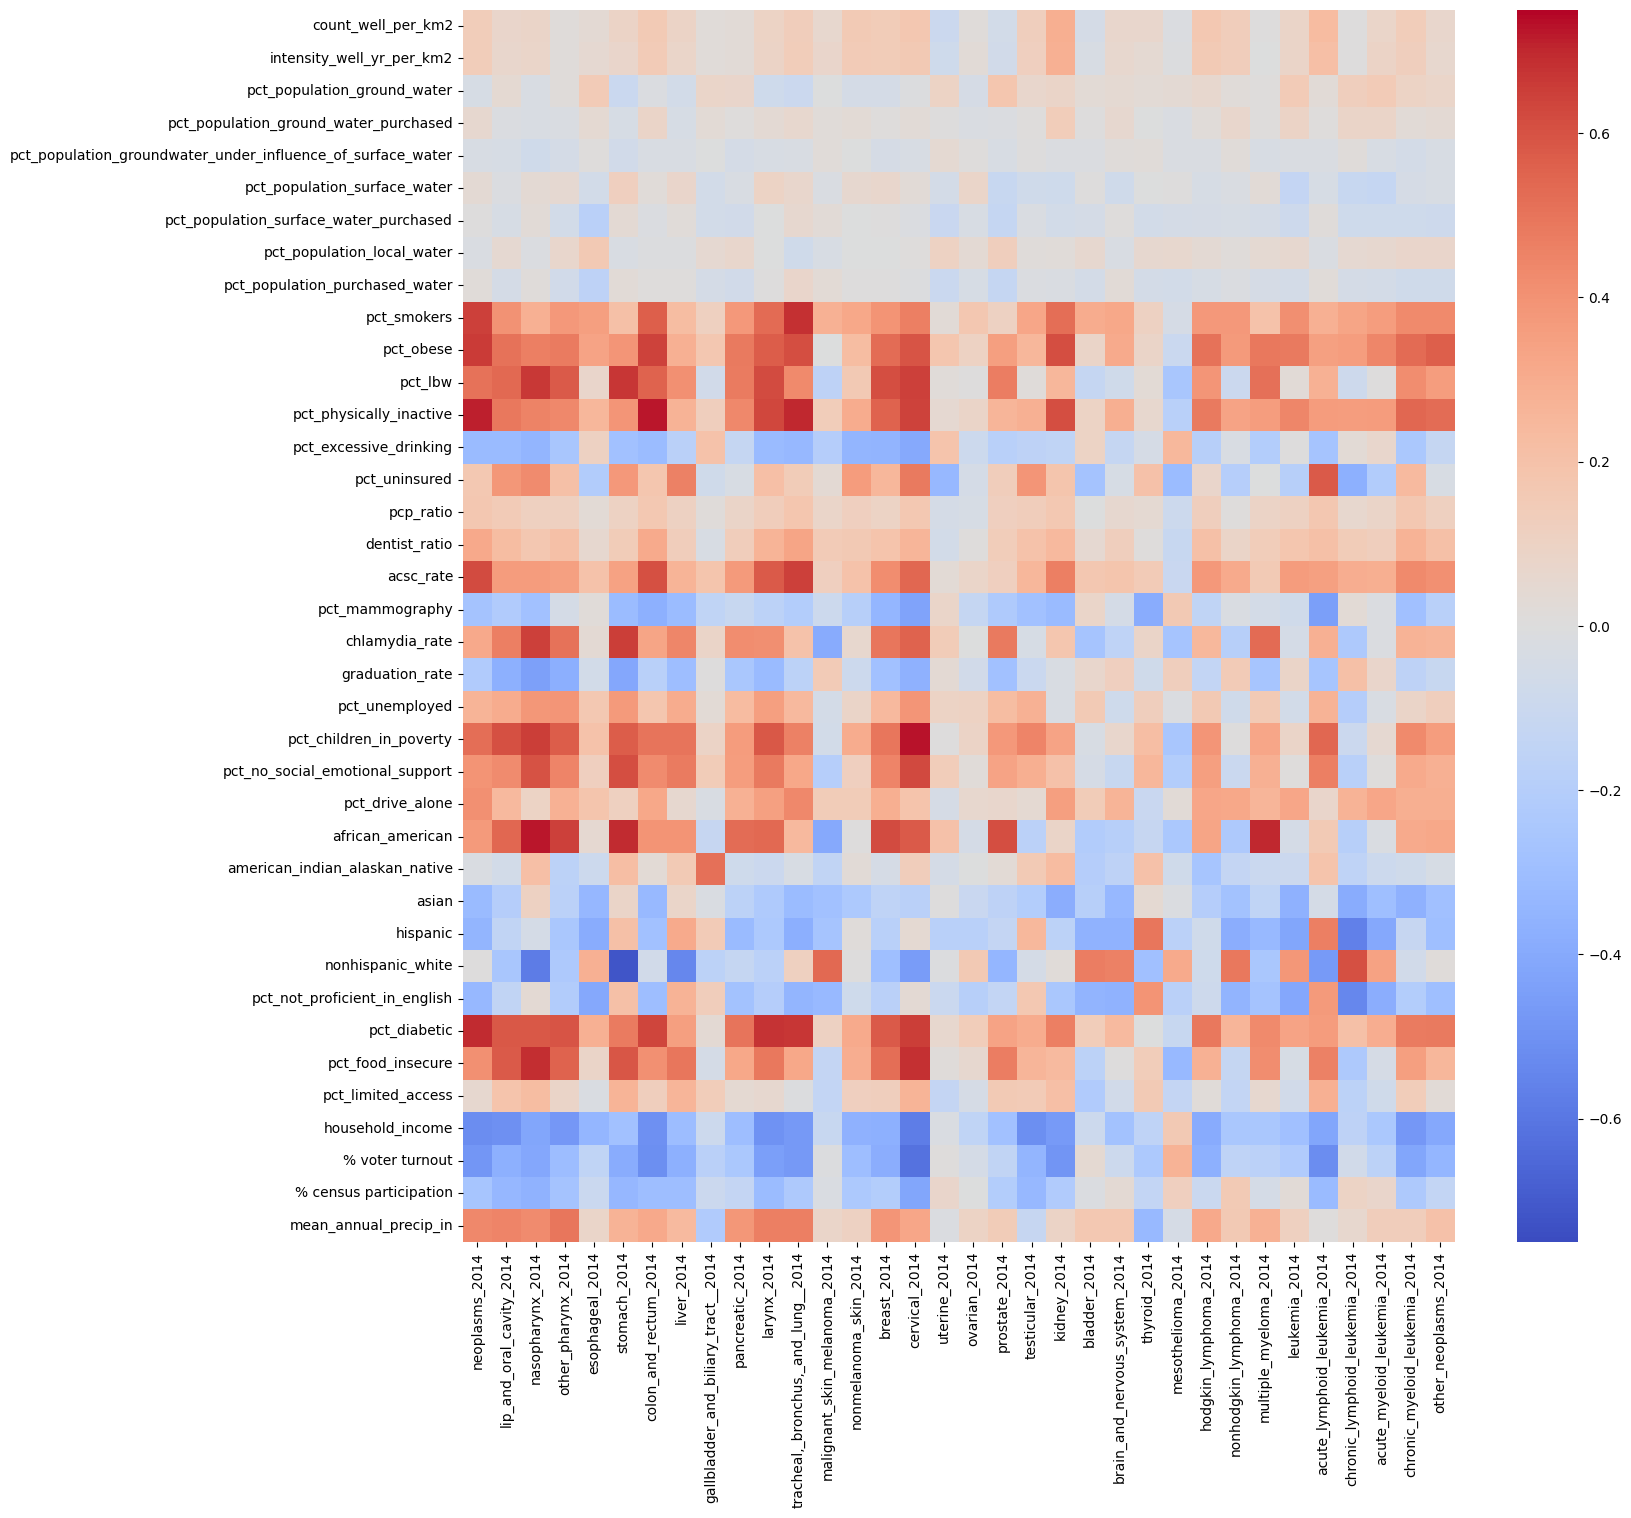

In [20]:
corr_df = df.dropna().select_dtypes(include=np.number).corr()
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(
    data=corr_df.loc[cancer_cols, all_cols].T,
    cmap="coolwarm",
    vmin=-0.75,
    vmax=0.75,
    ax=ax,
)

<Axes: >

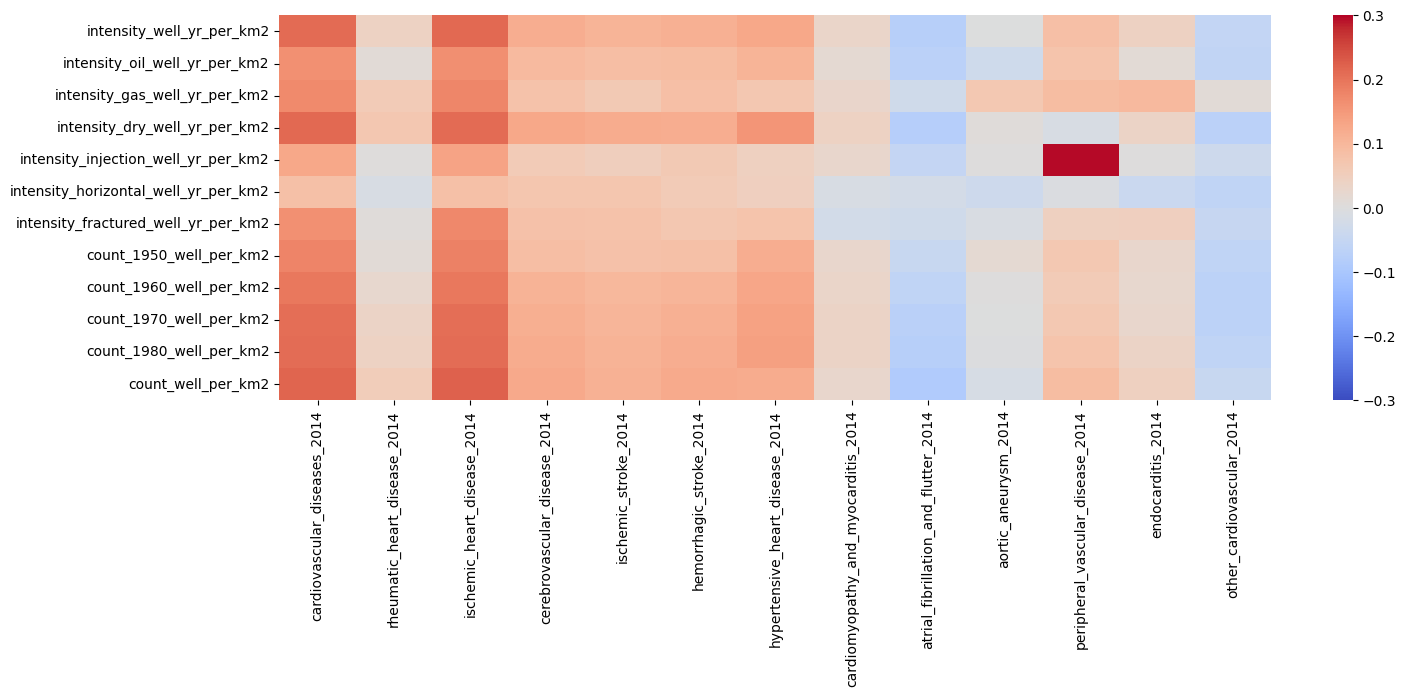

In [175]:
# OIL AND GAS CVD
corr_df = df.dropna().select_dtypes(include=np.number).corr()
fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(
    data=corr_df.loc[cvds, intensity_cols + og_time_cols + og_total_cols].T,
    cmap="coolwarm",
    vmin=-0.3,
    vmax=0.3,
    ax=ax,
)

<Axes: >

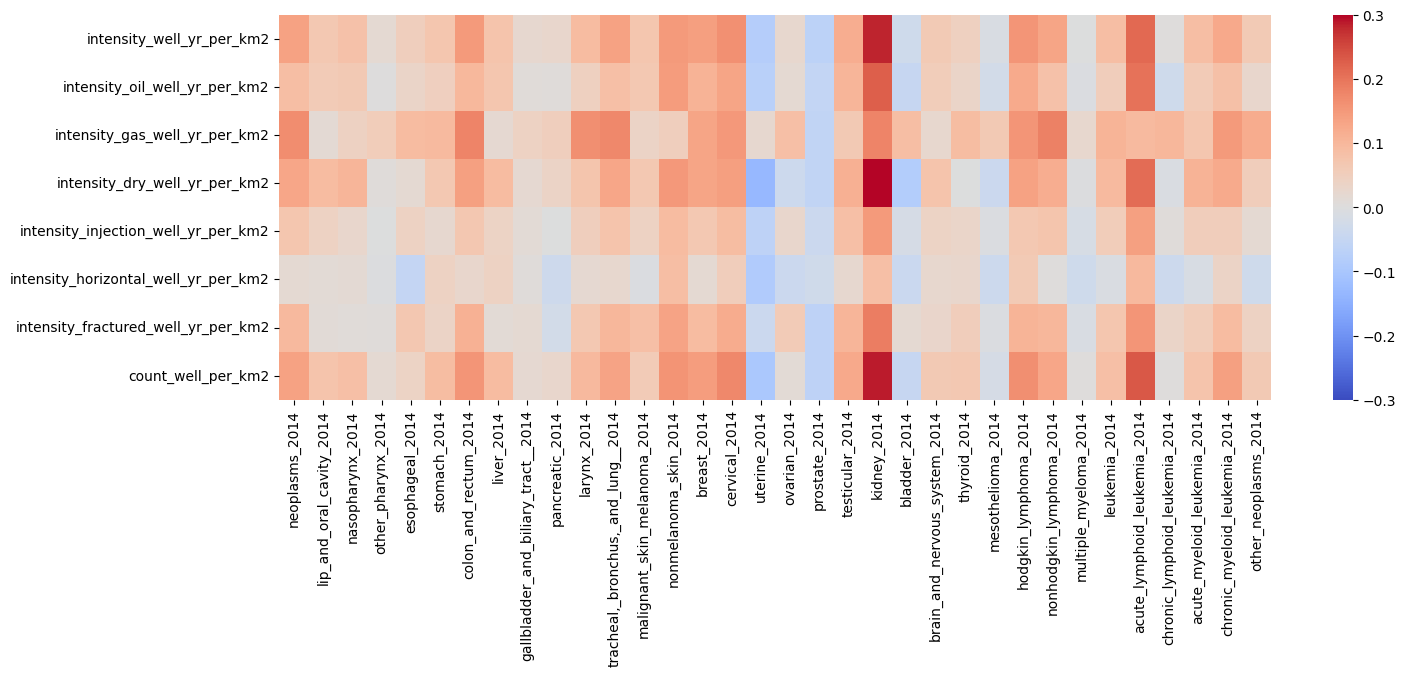

In [22]:
# OIL AND GAS
corr_df = df.dropna().select_dtypes(include=np.number).corr()
fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(
    data=corr_df.loc[cancer_cols, intensity_cols + og_total_cols].T,
    cmap="coolwarm",
    vmin=-0.3,
    vmax=0.3,
    ax=ax,
)

<Axes: >

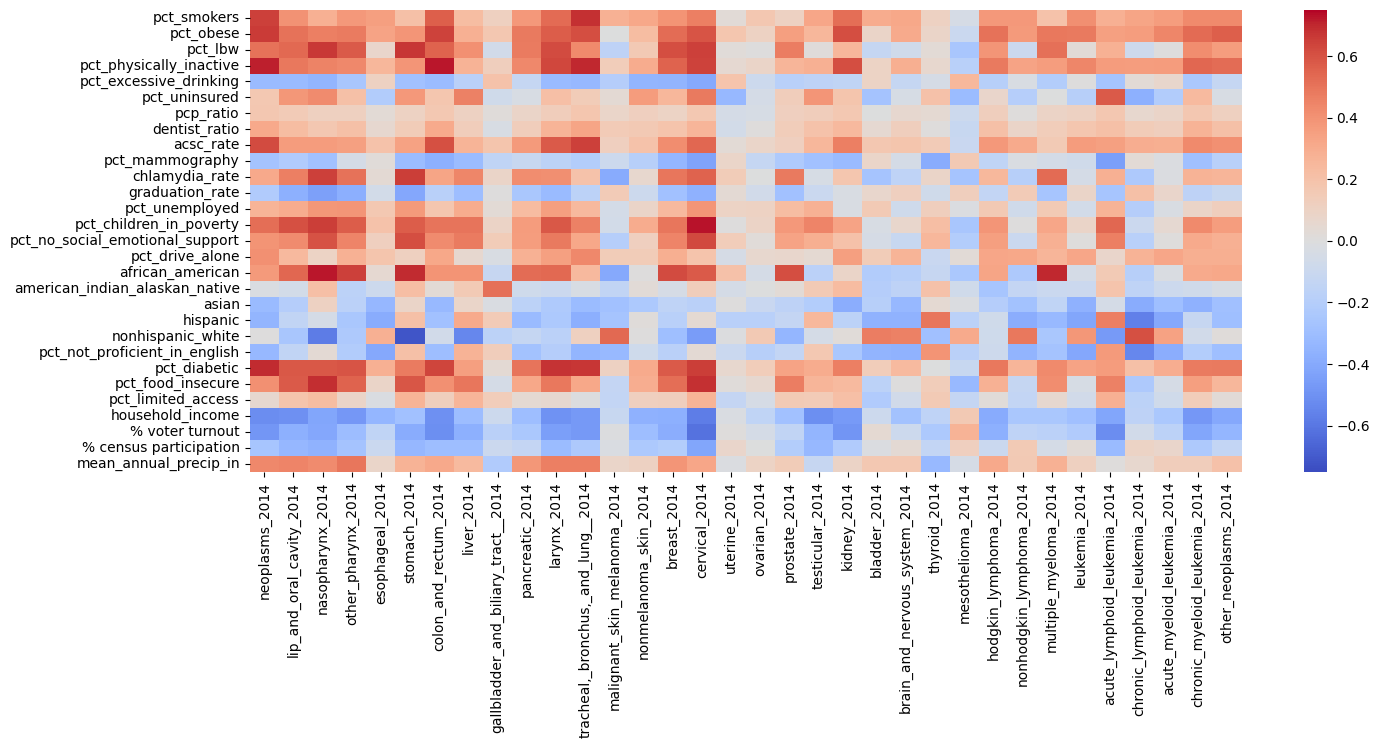

In [23]:
# standard risk factors
corr_df = df.dropna().select_dtypes(include=np.number).corr()
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(
    data=corr_df.loc[cancer_cols, risk_cols].T,
    cmap="coolwarm",
    vmin=-0.75,
    vmax=0.75,
    ax=ax,
)

<Axes: >

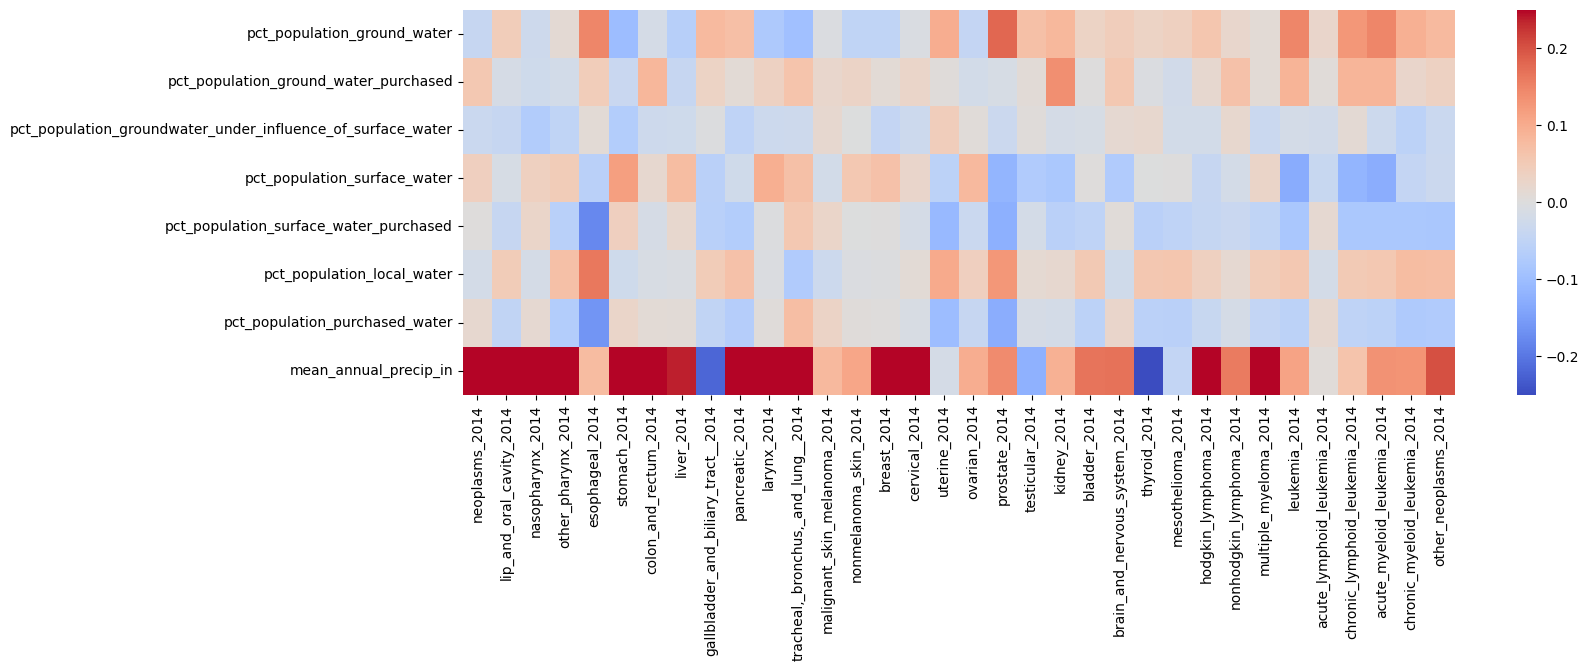

In [25]:
# Water source
corr_df = df.dropna().select_dtypes(include=np.number).corr()
fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(
    data=corr_df.loc[
        cancer_cols,
        [
            "pct_population_ground_water",
            "pct_population_ground_water_purchased",
            "pct_population_groundwater_under_influence_of_surface_water",
            "pct_population_surface_water",
            "pct_population_surface_water_purchased",
            "pct_population_local_water",
            "pct_population_purchased_water",
            "mean_annual_precip_in",
        ],
    ].T,
    cmap="coolwarm",
    vmin=-0.25,
    vmax=0.25,
    ax=ax,
)

<Axes: >

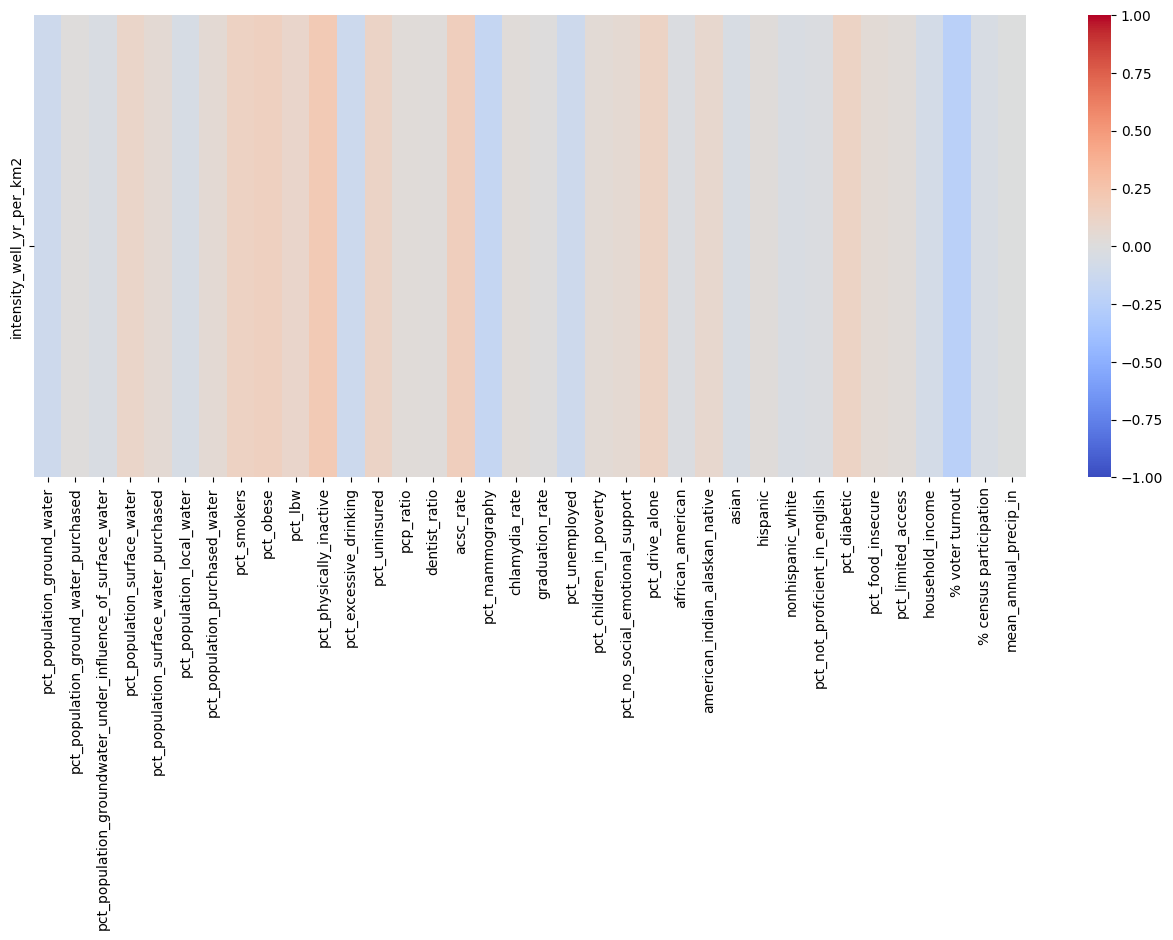

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.heatmap(
    ax=ax,
    data=corr_df.loc[og_total_intensity_col, water_cols + risk_cols],
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)

In [207]:
smart_cols = [
    "count_well_per_km2",
    # "intensity_well_yr_per_km2",
    "pct_population_ground_water",
    "pct_population_local_water",
    "pct_smokers",
    "pct_obese",
    "pct_physically_inactive",
    "pct_uninsured",
    "african_american",
    "american_indian_alaskan_native",
    "asian",
    "hispanic",
    "nonhispanic_white",
    "pct_food_insecure",
    "% voter turnout",
    "% census participation",
    "mean_annual_precip_in",
]

# smart_cols=og_count_cols+og_time_cols
smart_cols = [
    "% voter turnout",
    "pct_physically_inactive",
    "count_dry_well_per_km2",
    "pct_obese",
    "pct_uninsured",
    "pct_food_insecure",
    "pct_smokers",
    "pct_population_ground_water",
    #    "african_american",
    "american_indian_alaskan_native",
    #    "asian",
    #    "hispanic",
    "mean_annual_precip_in",
    "nonhispanic_white",
    # "count_1945_well_per_km2",
    # "count_1955_well_per_km2",
    # "count_1965_well_per_km2",
]

smart_cols = all_cols  # "count_well_per_km2"  # og_count_cols + og_time_cols

In [216]:
cvd_df.isna().sum()

fips                                    0
cardiovascular_diseases_2014            0
rheumatic_heart_disease_2014            0
ischemic_heart_disease_2014             0
cerebrovascular_disease_2014            0
ischemic_stroke_2014                    0
hemorrhagic_stroke_2014                 0
hypertensive_heart_disease_2014         0
cardiomyopathy_and_myocarditis_2014     0
atrial_fibrillation_and_flutter_2014    0
aortic_aneurysm_2014                    0
peripheral_vascular_disease_2014        0
endocarditis_2014                       0
other_cardiovascular_2014               0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance

rlist = []
elist = []
# split training and test set, ensuring that no hours from the same date are chosen to prevent memorization
score_df = pd.DataFrame()
data_df = df.dropna()
# data_df = df.loc[(df.state_name != "Oklahoma") & (df.state_name != "Texas")].dropna()
for rseed in [
    2,
    43,
    985,
    1,
    67,
    10002,
    32,
    11,
    10001,
    645,
    134,
    908,
    231,
    1232121,
    555,
    0,
    4,
    37,
    42,
    12367,
]:
    X_train, X_test, y_train, y_test = train_test_split(
        data_df[smart_cols],
        data_df["ischemic_stroke_2014"],
        test_size=0.3,
        random_state=rseed,
    )

    reg = XGBRegressor()

    parameters = {
        "max_depth": 4,
        "n_estimators": 1000,
        "learning_rate": 0.03,
    }  # ,objective:'binary:logistic'}
    reg.set_params(**parameters)
    reg.fit(X_train, y_train)
    reg.predict(X_test)
    y_pred = reg.predict(X_test)
    from sklearn.metrics import r2_score, mean_squared_error

    print(r2_score(y_test, y_pred))
    rlist.append(r2_score(y_test, y_pred))
    elist.append(mean_squared_error(y_test, y_pred) ** 0.5)
    feature_important = reg.get_booster().get_score(importance_type="gain")
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(
        by="score", ascending=False
    )
    data.rename(columns={"score": rseed}, inplace=True)
    if len(score_df) == 0:
        score_df = data
    else:
        score_df = score_df.merge(data, right_index=True, left_index=True)
    # data.nlargest(43, columns="score").plot(
#    kind="barh", figsize=(20, 10)
# )  ## plot top 40 features
print("")
print(np.mean(rlist))

0.23545004812222692
0.29676082472590537
0.18204315744203592
0.23649691536042872
0.16151277502648176
0.18056983003331462


In [191]:
smart_cols

['count_oil_well_per_km2',
 'count_gas_well_per_km2',
 'count_dry_well_per_km2',
 'count_injection_well_per_km2',
 'count_1950_well_per_km2',
 'count_1960_well_per_km2',
 'count_1970_well_per_km2',
 'count_1980_well_per_km2']

Text(0.5, 1.0, 'Kidney cancer mortality rate, 2014')

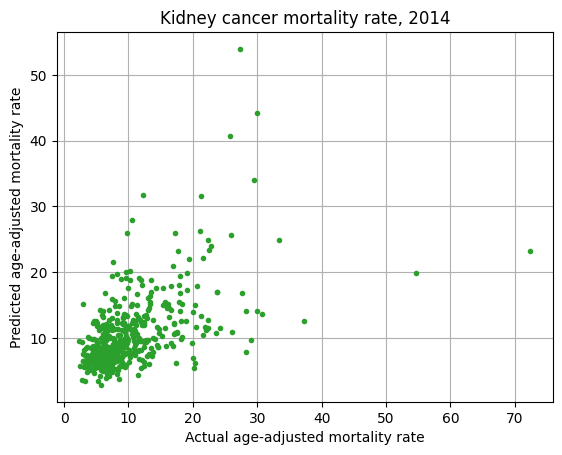

In [218]:
plt.plot(y_test, y_pred, ".", color="tab:green")
# plt.plot([2.5, 8], [2.5, 8], "gray")
# plt.xlim([2.5, 8])
# plt.ylim([2.5, 8])
plt.grid()
plt.xlabel("Actual age-adjusted mortality rate")
plt.ylabel("Predicted age-adjusted mortality rate")
plt.title("Kidney cancer mortality rate, 2014")

In [211]:
import shap

pred = reg.predict(df[smart_cols], output_margin=True)

explainer = shap.TreeExplainer(reg)
explanation = explainer(df[smart_cols])

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

0.00077819824

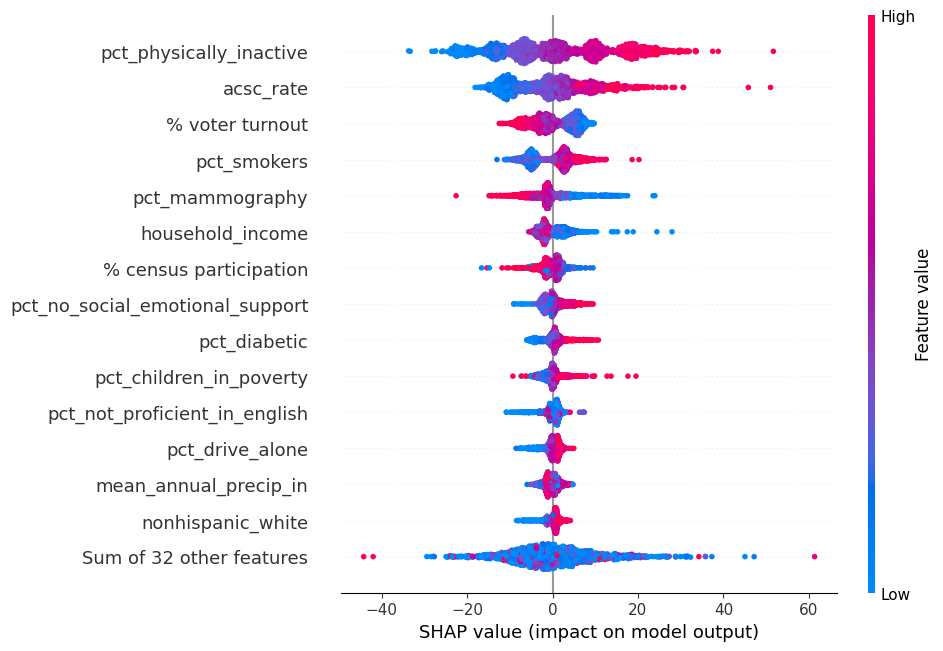

In [212]:
shap.plots.beeswarm(explanation, max_display=15)

In [ ]:
score_df.mean(axis=1).to_clipboard()

In [ ]:
cdc_df = pd.read_csv(
    DATA_DIR / Path("health/cdc_cause_of_death_2018-2021_by_county.csv")
)

In [ ]:
tmp = (
    cdc_df[["fips", "cause", "crude_rate"]]
    .pivot(index="fips", columns="cause")
    .reset_index()
)
tmp.columns = [x[0] if x[1] == "" else x[1] for x in tmp.columns.values]
tmp.columns = [
    x.split(" (")[0].replace("#", "").replace(",", "").lower()
    for x in tmp.columns.values
]
tmp.fips = [
    zero_pad(int(x), front_or_back="front", max_string_length=5) for x in tmp.fips
]

In [ ]:
df = df.merge(
    tmp[
        [
            "fips",
            "anemias",
            "cerebrovascular diseases",
            "chronic lower respiratory diseases",
            "diabetes mellitus",
            "essential hypertension and hypertensive renal disease",
            "nephritis nephrotic syndrome and nephrosis",
            "all other diseases",
        ]
    ],
    on="fips",
    how="outer",
)

In [ ]:
tmp=df.

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score, mean_squared_error

rlist = []
elist = []
# split training and test set, ensuring that no hours from the same date are chosen to prevent memorization
score_df = pd.DataFrame()
data_df = df.dropna().copy(deep=True)
for rseed in [
    2,
    43,
    985,
    1,
    67,
    10002,
    32,
    11,
    10001,
    645,
    134,
    908,
    231,
    1232121,
    555,
    0,
    4,
    37,
    42,
    12367,
]:
    X_train, X_test, y_train, y_test = train_test_split(
        data_df[smart_cols],
        data_df["acute_lymphoid_leukemia_2014"],
        test_size=0.3,
        random_state=rseed,
    )

    reg = XGBRegressor()

    parameters = {
        "max_depth": 4,
        "n_estimators": 500,
        "learning_rate": 0.1,
    }  # ,objective:'binary:logistic'}
    reg.set_params(**parameters)
    reg.fit(X_train, y_train)
    reg.predict(X_test)
    y_pred = reg.predict(X_test)

    rlist.append(r2_score(y_test, y_pred))
    elist.append(mean_squared_error(y_test, y_pred) ** 0.5)
    feature_important = reg.get_booster().get_score(importance_type="gain")
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(
        by="score", ascending=False
    )
    data.rename(columns={"score": rseed}, inplace=True)
    if len(score_df) == 0:
        score_df = data
    else:
        score_df = score_df.merge(data, right_index=True, left_index=True)
    # data.nlargest(43, columns="score").plot(
#    kind="barh", figsize=(20, 10)
# )  ## plot top 40 features
print("")
print(np.mean(rlist))
print("")
print(np.mean(elist))

In [ ]:
import shap

pred = reg.predict(data_df[smart_cols], output_margin=True)

explainer = shap.TreeExplainer(reg)
explanation = explainer(data_df[smart_cols])

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

In [ ]:
smart_cols = [
    "intensity_well_yr_per_km2",
    "pct_population_ground_water",
    "pct_population_local_water",
    "pct_smokers",
    "pct_obese",
    "pct_physically_inactive",
    "household_income",
    "pct_uninsured",
    # "african_american",
    # "american_indian_alaskan_native",
    # "asian",
    # "hispanic",
    "pct_diabetic",
    # "nonhispanic_white",
    "pct_food_insecure",
]

In [ ]:
shap.plots.beeswarm(explanation, max_display=20)

In [ ]:
df

In [ ]:
df

In [ ]:
corr2_df=df.dropna().select_dtypes(include=np.number).corr()
sns.heatmap(corr2_df.loc[[            "anemias",
            "cerebrovascular diseases",
            "chronic lower respiratory diseases",
            "diabetes mellitus",
            "essential hypertension and hypertensive renal disease",
            "nephritis nephrotic syndrome and nephrosis",
            "all other diseases",
        ],all_cols], cmap="coolwarm")